In [1]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from class_count import save_extracted_tiff, get_class_counts
from data_fetching import fetch_inmet_data
from regression_pipeline import preprocess_data, train_and_evaluate_model, impute_missing_values, run_pipeline

In [2]:
import pandas as pd
import numpy as np
import glob
import requests
import matplotlib.pyplot as plt

# Temperatura ao decorrer dos anos

In [7]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

In [ ]:
all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

In [ ]:
combined_data.head()

,mes,hora,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,temperatura_bulbo_hora,temperatura_orvalho_hora,temperatura_max,...,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade,data,id_estacao,ano
0,5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.263443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-05-21,A305,2003
1,5,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.366230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-05-23,A305,2003
2,6,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.389454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-08,A305,2003
3,6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.304260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-16,A305,2003
4,6,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.344181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-06-18,A305,2003


In [ ]:
combined_data['id_estacao'].unique()

array(['A305', 'A306', 'A307', 'A308', 'A408', 'A412', 'A309', 'A310',
       'A313', 'A413', 'A415', 'A416', 'A417', 'A418', 'A526', 'A539',
       'A543', 'A314', 'A315', 'A316', 'A317', 'A318', 'A319', 'A321',
       'A322', 'A323', 'A324', 'A325', 'A327', 'A329', 'A330', 'A331',
       'A332', 'A333', 'A334', 'A336', 'A337', 'A339', 'A340', 'A358',
       'A359', 'A419', 'A420', 'A423', 'A424', 'A425', 'A426', 'A428',
       'A429', 'A430', 'A432', 'A433', 'A435', 'A436', 'A439', 'A440',
       'A441', 'A442', 'A443', 'A348', 'A349', 'A347', 'A350', 'A342',
       'A343', 'A354', 'A351', 'A345', 'A328', 'A360', 'A365', 'A366',
       'A367', 'A448', 'A450', 'A559', 'A563', 'A449', 'A454', 'A451',
       'A453', 'A370', 'A371', 'A372', 'A373', 'A458', 'A368', 'A369'],
      dtype=object)

In [ ]:
# Novo dataset com as colunas de interesse
temperaturas = combined_data[['data', 'temperatura_max', 'temperatura_min', 'ano']]

# Agrupar por ano
temperatura_anual = temperaturas.groupby('ano').agg({
    'temperatura_max': 'max',
    'temperatura_min': 'min'
}).reset_index()

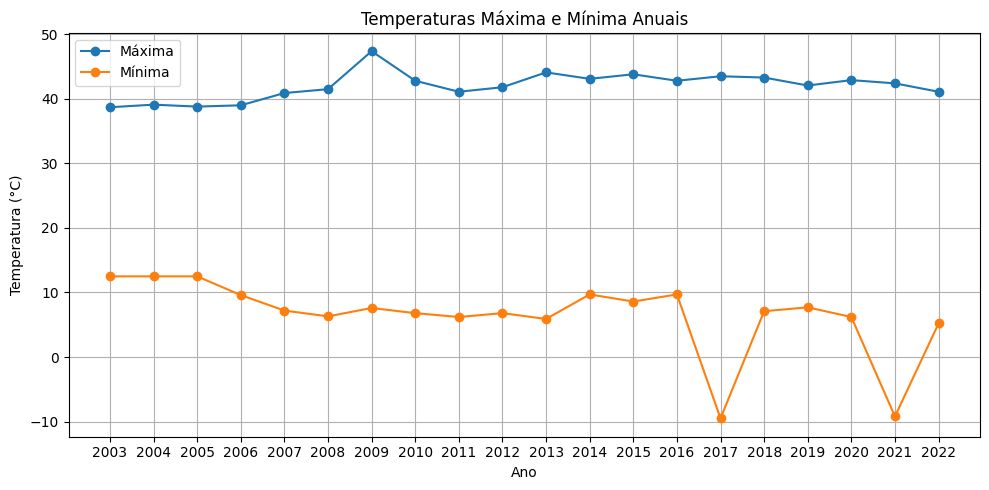

In [ ]:
# Visualizar a série temporal
# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais')
plt.xticks(range(2003, 2023))  # Define os ticks do eixo x para cada ano de 2003 a 2022
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço ao conteúdo
plt.show()

Provavelmente ocorreu um erro em alguma estação que resultou em uma temperatura negativa em 2017 e 2021, vamos avaliar o dataset antes da regressão.

In [3]:
df_meta_dados_2017 = fetch_inmet_data([2017])
df_meta_dados_2017['temperatura_min'].describe()

Downloading: 100%|██████████| 712656/712656 [03:26<00:00, 3455.80rows/s]


count    663641.000000
mean         25.456288
std           4.353675
min          -9.500000
25%          22.400000
50%          25.000000
75%          28.500000
max          40.100000
Name: temperatura_min, dtype: float64

In [4]:
# verificar em qual estação ocorre a temperatura -9.5
df_meta_dados_2017[df_meta_dados_2017['temperatura_min'] == -9.5]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
444046,2017,11,2017-11-29,07:00:00,A372,0.0,1009.7,1009.7,1009.4,84.7,...,26.4,-9.5,NaN,NaN,NaN,NaN,NaN,61.0,2.5,0.2


As estações podem sofrer panes, então provavelmente a temperatura negativa é um erro de medição. Já que essa estação fica em IPANGUACU RN, que é uma cidade quente, é improvável que a temperatura tenha sido negativa.

In [5]:
# verificar quantas temperaturas negativas existem
df_meta_dados_2017[df_meta_dados_2017['temperatura_min'] < 0]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
443481,2017,12,2017-12-05,06:00:00,A372,0.0,1008.4,1008.4,1008.2,97.1,...,27.5,-4.7,NaN,NaN,NaN,NaN,NaN,351.0,2.2,0.0
443531,2017,12,2017-12-02,03:00:00,A372,0.0,1008.9,1009.6,1008.9,79.5,...,27.7,-2.6,NaN,NaN,NaN,NaN,NaN,81.0,5.0,1.7
443676,2017,12,2017-12-01,04:00:00,A372,0.0,1007.3,1007.8,1007.3,54.8,...,26.9,-8.7,NaN,NaN,NaN,NaN,NaN,68.0,2.4,0.5
444046,2017,11,2017-11-29,07:00:00,A372,0.0,1009.7,1009.7,1009.4,84.7,...,26.4,-9.5,NaN,NaN,NaN,NaN,NaN,61.0,2.5,0.2
444264,2017,11,2017-11-21,08:00:00,A372,0.0,1009.1,1009.1,1008.5,3.5,...,23.5,-7.4,NaN,NaN,NaN,NaN,NaN,68.0,3.5,0.0


In [6]:
# verificar quantas temperaturas negativas existem
df_meta_dados_2017[df_meta_dados_2017['temperatura_max'] < 0]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade


In [7]:
# verificar quantas temperaturas 0 existem
df_meta_dados_2017[df_meta_dados_2017['temperatura_min'] == 0]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
334435,2017,3,2017-03-16,05:00:00,A347,0.0,941.5,943.0,941.1,NaN,...,20.7,0.0,19.5,18.1,93.0,65.0,NaN,111.0,0.0,0.0
340178,2017,3,2017-03-15,11:00:00,A347,0.0,960.6,960.9,959.9,4.8,...,22.2,0.0,20.8,15.2,93.0,74.0,92.0,79.0,0.0,0.0


In [8]:
# Transformar em NAN as ocorrências de temperaturas negativas
df_meta_dados_2017.loc[df_meta_dados_2017['temperatura_min'] <= 0, 'temperatura_min'] = np.nan

In [9]:
df_meta_dados_2017.head()

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
0,2017,10,2017-10-01,23:00:00,A559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,10,2017-10-03,05:00:00,A559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,10,2017-10-20,18:00:00,A559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,10,2017-10-20,21:00:00,A559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,11,2017-11-01,00:00:00,A559,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Agora para o ano de 2021

In [10]:
df_meta_dados_2021 = fetch_inmet_data([2021])
df_meta_dados_2021['temperatura_min'].describe()

Downloading: 100%|██████████| 762120/762120 [02:51<00:00, 4431.08rows/s]


count    377837.000000
mean         25.370672
std           4.310289
min          -9.200000
25%          22.300000
50%          25.000000
75%          28.400000
max          39.700000
Name: temperatura_min, dtype: float64

In [11]:
# verificar em qual estação ocorre a temperatura -9.2
df_meta_dados_2021[df_meta_dados_2021['temperatura_min'] == -9.2]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
757622,2021,11,2021-11-10,13:00:00,A372,0.0,1009.9,1010.3,1009.8,42.6,...,33.5,-9.2,NaN,NaN,NaN,NaN,45.0,95.0,9.1,3.5


Novamente a mesma estação, com temperatura negativa

In [12]:
# verificar quantas temperaturas negativas existem
df_meta_dados_2021[df_meta_dados_2021['temperatura_min'] < 0]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
757622,2021,11,2021-11-10,13:00:00,A372,0.0,1009.9,1010.3,1009.8,42.6,...,33.5,-9.2,NaN,NaN,NaN,NaN,45.0,95.0,9.1,3.5


Dessa vez foi apenas uma ocorrência

In [13]:
# verificar quantas temperaturas 0 existem
df_meta_dados_2021[df_meta_dados_2021['temperatura_max'] == 0]

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade


In [14]:
# Transformar em NaN as ocorrências de temperaturas negativas
df_meta_dados_2021.loc[df_meta_dados_2021['temperatura_min'] < 0, 'temperatura_min'] = np.nan

In [15]:
df_meta_dados_2021.head()

,ano,mes,data,hora,id_estacao,precipitacao_total,pressao_atm_hora,pressao_atm_max,pressao_atm_min,radiacao_global,...,temperatura_max,temperatura_min,temperatura_orvalho_max,temperatura_orvalho_min,umidade_rel_max,umidade_rel_min,umidade_rel_hora,vento_direcao,vento_rajada_max,vento_velocidade
0,2021,11,2021-11-25,19:00:00,A539,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,11,2021-11-25,18:00:00,A539,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,12,2021-12-05,19:00:00,A539,0.0,960.0,960.6,960.0,804.4,...,31.0,27.7,20.0,17.9,61.0,49.0,59.0,123.0,8.9,0.2
3,2021,11,2021-11-08,07:00:00,A539,0.8,960.0,960.0,959.4,NaN,...,22.1,22.0,20.6,20.4,92.0,90.0,91.0,68.0,3.7,1.6
4,2021,10,2021-10-14,03:00:00,A539,0.0,960.0,960.6,960.0,NaN,...,23.7,22.5,19.3,18.9,81.0,75.0,81.0,343.0,1.7,0.4


Agora vamos aplicar novamente a regressão

In [16]:
# Lista das colunas alvo
target_columns = [
    'temperatura_max',
    'temperatura_min'
]

df_meta_dados_2017_imputed = run_pipeline(df_meta_dados_2017, target_columns)

# Salvar o dataset com valores imputados na pasta estacoes
df_meta_dados_2017_imputed.to_csv('../dados/estacoes/dataset_imputed_2017.csv', index=False)

Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08083556019580727
Mean Absolute Error: 0.20861925841966594
R² Score: 0.9962238953474679
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.08731498345607935
Mean Absolute Error: 0.22146381294878412
R² Score: 0.9956270756352058
Remaining missing values in temperatura_min: 0


In [17]:
# Lista das colunas alvo
target_columns = [
    'temperatura_max',
    'temperatura_min'
]

df_meta_dados_2021_imputed = run_pipeline(df_meta_dados_2021, target_columns)

# Salvar o dataset com valores imputados na pasta estacoes
df_meta_dados_2021_imputed.to_csv('../dados/estacoes/dataset_imputed_2021.csv', index=False)

Processing target column: temperatura_max
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.09001508400981278
Mean Absolute Error: 0.21728299373732282
R² Score: 0.9955126437579576
Remaining missing values in temperatura_max: 0
Processing target column: temperatura_min
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mean Squared Error: 0.10117656880171126
Mean Absolute Error: 0.2388862747199775
R² Score: 0.9946533269519375
Remaining missing values in temperatura_min: 0


In [20]:
path = '../dados/estacoes'  
all_files = glob.glob(path + "/*.csv")  

all_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    all_data.append(df)

combined_data = pd.concat(all_data, axis=0, ignore_index=True)

# Novo dataset com as colunas de interesse
temperaturas = combined_data[['id_estacao','data', 'temperatura_max', 'temperatura_min', 'ano']]

# Agrupar por ano
temperatura_anual = temperaturas.groupby('ano').agg({
    'temperatura_max': 'max',
    'temperatura_min': 'min'
}).reset_index()

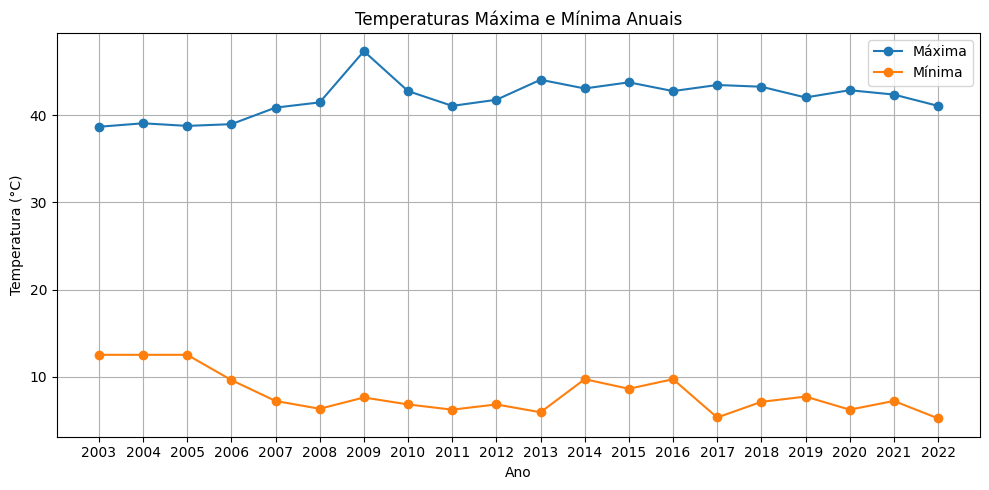

In [21]:
# Visualizar a série temporal
# Criando o gráfico
plt.figure(figsize=(10, 5))  # Ajusta o tamanho do gráfico
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_max'], label='Máxima', marker='o')
plt.plot(temperatura_anual['ano'], temperatura_anual['temperatura_min'], label='Mínima', marker='o')

plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.title('Temperaturas Máxima e Mínima Anuais')
plt.xticks(range(2003, 2023))  # Define os ticks do eixo x para cada ano de 2003 a 2022
plt.legend()
plt.grid(True)  # Adiciona uma grade para melhor visualização
plt.tight_layout()  # Ajusta automaticamente os subplots para dar espaço ao conteúdo
plt.show()

# Segmentações ao decorrer dos anos

In [ ]:
# Diretório onde os arquivos serão salvos
save_dir = '../dados/segmentacoes'

# Lista de anos
years = range(2003, 2022)  

# Loop para baixar os arquivos
for year in years:
    # Construindo a URL para o ano atual
    url = f'https://storage.googleapis.com/mapbiomas-public/initiatives/brasil/collection_8/lclu/coverage/brasil_coverage_{year}.tif'
    
    # Nome do arquivo local onde o TIF será salvo
    local_filename = f'{save_dir}brasil_coverage_{year}.tif'

    # Fazendo a requisição para baixar o arquivo
    response = requests.get(url)
    
    # Verificando se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Garantindo que o diretório exista
        os.makedirs(save_dir, exist_ok=True)
        
        # Escrevendo o conteúdo do arquivo baixado no arquivo local
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        print(f'Arquivo {local_filename} baixado e salvo com sucesso.')
    else:
        print(f'Falha ao baixar o arquivo para o ano {year}.')

Arquivo ../dados/segmentacoesbrasil_coverage_2000.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2001.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2002.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2003.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2004.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2005.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2006.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2007.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2008.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2009.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2010.tif baixado e salvo com sucesso.
Arquivo ../dados/segmentacoesbrasil_coverage_2011.tif baixado e salvo com sucesso.
Arqu

In [ ]:
def process_all_years_and_save(base_raster_path, biomes_shp, output_base_path, start_year=2003, end_year=2022, biome_name='Caatinga'):
    """
    Esta função processa os arquivos raster para todos os anos de 2003 a 2022,
    extrai a região do bioma especificado e salva o resultado em arquivos GeoTiff.
    """
    for year in range(start_year, end_year + 1):
        raster_file = os.path.join(base_raster_path, f'segmentacoesbrasil_coverage_{year}.tif')
        output_tiff = os.path.join(output_base_path, f'caatinga_extracted_{year}.tif')
        
        print(f'Processing and saving year {year}...')
        
        # Chama a função para salvar o GeoTiff extraído
        save_extracted_tiff(raster_file, biomes_shp, biome_name=biome_name, output_tiff_path=output_tiff)
        
        print(f'Saved extracted GeoTiff for year {year} at {output_tiff}')

# Configurações
base_raster_path = '../dados/segmentacoes' 
biomes_shp = '../dados/Biomas_250mil/lm_bioma_250.shp'
output_base_path = '../dados/extracted_tiff_caatinga'

# Garantir que a pasta de saída exista
os.makedirs(output_base_path, exist_ok=True)

# Processar e salvar todos os anos de 2003 a 2022
process_all_years_and_save(base_raster_path, biomes_shp, output_base_path)

Processing and saving year 2003...
Saved extracted GeoTiff for year 2003 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2003.tif
Processing and saving year 2004...
Saved extracted GeoTiff for year 2004 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2004.tif
Processing and saving year 2005...
Saved extracted GeoTiff for year 2005 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2005.tif
Processing and saving year 2006...
Saved extracted GeoTiff for year 2006 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2006.tif
Processing and saving year 2007...
Saved extracted GeoTiff for year 2007 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2007.tif
Processing and saving year 2008...
Saved extracted GeoTiff for year 2008 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2008.tif
Processing and saving year 2009...
Saved extracted GeoTiff for year 2009 at ../dados/extracted_tiff_caatinga\caatinga_extracted_2009.tif
Processing and saving year 2010...
Saved 

## Agora precisamos delimitar pelas estações